In [1]:
import logging
from tqdm import tqdm
import arviz as az
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pytensor as pyt
from random import randint
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

Importing plotly failed. Interactive plots will not work.


In [31]:
class MyProphet():
    def __init__(self,
                 n_changepoints=25,
                 changepoints_prior_scale=0.05,
                 changepoint_range=0.8,
                 seasonality_prior_scale=10.0,
                 mcmc_samples=0,
                ):
        self.n_changepoints = n_changepoints
        self.changepoints_prior_scale = changepoints_prior_scale
        self.changepoint_range = changepoint_range
        self.seasonality_prior_scale = seasonality_prior_scale
        self.mcmc_samples = mcmc_samples
        
        self.model = None
        self.trend_params = None
        self.yearly_seasonality_params = None
        self.weekly_seasonality_params = None
        self.map_approx = None
        self.trace = None
        self.posterior = None
        
        self.data = None
        self.y_min = None
        self.y_max = None
        self.ds_min = None
        self.ds_max = None

    def _scale_data(self):
        self.y_min = 0
        self.y_max = self.data["y"].abs().max()
        self.ds_min = self.data["ds"].min()
        self.ds_max = self.data["ds"].max()

        self.data["y"] = self.data["y"] / self.y_max
        self.data["t"] = (self.data["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        
    def _process_data(self):
        self.data["ds"] = pd.to_datetime(self.data["ds"])
        self.data.sort_values("ds", inplace=True)
        self._scale_data()

    def _add_trend(self):
        t = np.array(self.data["t"])
        s = np.linspace(0, self.changepoint_range * np.max(t), self.n_changepoints + 1)[1:]
    
        # * 1 casts the boolean to integers
        A = (t[:, None] > s) * 1
    
        with self.model:
            # initial growth
            k = pm.Normal("k", 0 , 5)

            changepoints_prior_scale = self.changepoints_prior_scale
            if self.changepoints_prior_scale is None:
                changepoints_prior_scale = pm.Exponential("tau", 1.5)
        
            # rate of change
            delta = pm.Laplace("delta", 0, changepoints_prior_scale, shape=self.n_changepoints)
            # offset
            m = pm.Normal("m", 0, 5)
            gamma = -s * delta
            trend = pm.Deterministic("trend", (k + pyt.tensor.dot(A, delta)) * t + (m + pyt.tensor.dot(A, gamma)))

        return trend, A, s

    def _fourier_series(self, data, p=365.25, n=10):
        x = 2 * np.pi * np.arange(1, n + 1) / p
        x = x * np.array(data["t"])[:, None]
        x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
        return x

    def _get_seasonality_n_x(self, data, period):
        if period == "yearly":
            n = 10
            p = 365.25
        else:  # weekly
            n = 3
            p = 7

        # rescale the period, as t is also scaled
        p /= (self.ds_max - self.ds_min).days
            
        return n, self._fourier_series(data, p, n)

    def _add_seasonality(self, period):
        n, x = self._get_seasonality_n_x(self.data, period)
    
        with self.model:
            beta = pm.Normal(f"beta_{period}", mu=0, sigma=self.seasonality_prior_scale, shape=2 * n)
            
        return x, beta

    def fit(self, data):
        self.data = data.copy()
        self._process_data()

        self.model = pm.Model()
        with self.model:
            trend, A, s = self._add_trend()
            x_yearly, beta_yearly = self._add_seasonality("yearly")
            x_weekly, beta_weekly = self._add_seasonality("weekly")
            trend += pyt.tensor.dot(x_yearly, beta_yearly) + pyt.tensor.dot(x_weekly, beta_weekly)
            # sigma = pm.HalfCauchy("sigma", 0.5, initval=1)
            sigma = pm.HalfNormal("sigma", 0.5, initval=1)
            obs = pm.Normal("obs", mu=trend, sigma=sigma, observed=self.data["y"])
            
            if self.mcmc_samples == 0:
                self.map_approx = pm.find_MAP(progressbar=False)
            else:
                self.trace = pm.sample(self.mcmc_samples, return_inferencedata=True, cores=6, chains=4)
                self.posterior = pm.sample_posterior_predictive(trace=self.trace)

        self.trend_params = (trend, A, s)
        self.yearly_seasonality_params = (x_yearly, beta_yearly)
        self.weekly_seasonality_params = (x_weekly, beta_weekly)

    def _det_seasonality_posterior(self, beta, x):
        return np.dot(x, beta.T)

    def _plot_predictions(self, future, y_true=None):
        date = future["ds"].dt.to_pydatetime()
        plt.figure(figsize=(16, 3*6))
        b = 411
        plt.subplot(b)
        plt.title("Predictions")
        plt.plot(date, future["yhat"], lw=0.5)
        plt.scatter(date[:len(self.data)], self.data["y"] * self.y_max, s=0.5, color="black")

        if y_true is not None:
            plt.scatter(date[len(self.data):], y_true, s=0.5, color="green")

    def _make_future_df(self, days):
        future = pd.DataFrame({
            "ds": pd.DatetimeIndex(pd.concat((
                self.data["ds"], 
                pd.date_range(self.ds_max, self.ds_max + pd.Timedelta(days, "D"), inclusive="right").to_series(),
            )))
        })
        future["t"] = (future["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        return future
    
    def _predict_map(self, days, y_true=None, plot=False):
        trend, A, s = self.trend_params
        history_points = self.data.shape[0]
        probability_changepoint = self.n_changepoints / history_points
        future = self._make_future_df(days)
        
        _, x_yearly = self._get_seasonality_n_x(future, "yearly")
        _, x_weekly = self._get_seasonality_n_x(future, "weekly")
        
        yearly_posterior = self._det_seasonality_posterior(self.map_approx["beta_yearly"], x_yearly) * self.y_max
        weekly_posterior = self._det_seasonality_posterior(self.map_approx["beta_weekly"], x_weekly) * self.y_max
        
        trend_forecast = []
        future_t = np.array(future["t"])
        
        new_changepoints = future["t"][future["t"] > 1].values
        sample = np.random.random(new_changepoints.shape)
        new_changepoints = new_changepoints[sample <= probability_changepoint]
        new_s = np.r_[s, new_changepoints]
        tau = self.map_approx["tau"] if self.changepoints_prior_scale is None else self.changepoints_prior_scale
        new_delta = np.r_[self.map_approx["delta"], stats.laplace(0, tau).rvs(new_changepoints.shape[0])]
        new_A = (future_t[:, None] > new_s) * 1
        
        trend_forecast = np.array((
            (self.map_approx["k"] + np.dot(new_A, new_delta)) * future["t"] + 
            (self.map_approx["m"] + np.dot(new_A, (-new_s * new_delta)))
        ) * self.y_max)

        future["yhat"] = trend_forecast + yearly_posterior + weekly_posterior

        if plot:
            self._plot_predictions(future, y_true)
            
        return future

    def _predict_mcmc(self, days, y_true=None, plot=False):
        _, _, s = self.trend_params
        history_points = df.shape[0]
        probability_changepoint = self.n_changepoints / history_points
        future = self._make_future_df(days)

        yearly_n, x_yearly = self._get_seasonality_n_x(future, "yearly")
        weekly_n, x_weekly = self._get_seasonality_n_x(future, "weekly")
        
        beta_yearly = self.trace["posterior"]["beta_yearly"].to_numpy().mean(0)
        beta_weekly = self.trace["posterior"]["beta_weekly"].to_numpy().mean(0)
        delta = self.trace["posterior"]["delta"].mean(["chain", "draw"])
        k = self.trace["posterior"]["k"].mean().to_numpy()
        m = self.trace["posterior"]["m"].mean().to_numpy()
        
        trend_forecast = []
        tau = self.trace["posterior"]["tau"].mean() if self.changepoints_prior_scale is None else self.changepoints_prior_scale
        
        future_t = np.array(future["t"])
        
        yearly_posterior = self._det_seasonality_posterior(beta_yearly, x_yearly) * self.y_max
        weekly_posterior = self._det_seasonality_posterior(beta_weekly, x_weekly) * self.y_max
        
        for n in range(self.mcmc_samples):
            new_changepoints = future["t"][future["t"] > 1].values
            sample = np.random.random(new_changepoints.shape)
            new_changepoints = new_changepoints[sample <= probability_changepoint]
            new_delta = np.r_[delta, stats.laplace(0, tau).rvs(new_changepoints.shape[0])]
            new_s = np.r_[s, new_changepoints]
            new_A = (future_t[:, None] > new_s) * 1
            trend_forecast.append(((k + np.dot(new_A, new_delta)) * future['t']  + (m + np.dot(new_A, (-new_s * new_delta)))) * df['y'].max())   
            
        trend_forecast = np.array(trend_forecast)
        
        future["yhat"] = (trend_forecast + yearly_posterior.T + weekly_posterior.T).mean(0)

        if plot:
            self._plot_predictions(future, y_true)
        
        return future
        

In [28]:
df = pd.read_csv("https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv")
df

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871


/tmp/ipykernel_23064/4182413457.py:122: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


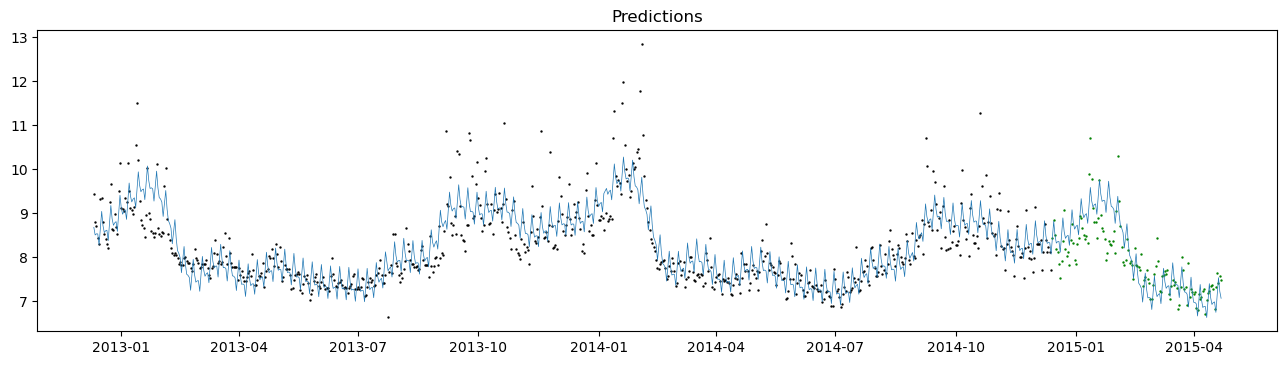

In [29]:
window = 730
horizon = 130
start = randint(0, len(df) - window - horizon - 1)

model = MyProphet()
model.fit(df[start:start + window])
preds = model._predict_map(horizon, y_true=df[start + window:start + window + horizon]["y"], plot=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 79 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [obs]


Output()

/tmp/ipykernel_23064/2443599395.py:122: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


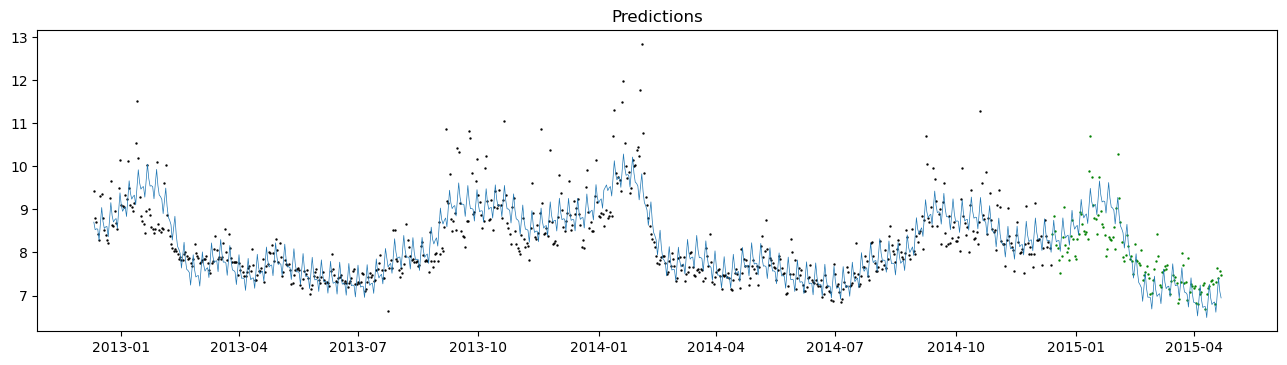

In [33]:
model = MyProphet(mcmc_samples=100)
model.fit(df[start:start + window])
mcmc_preds = model._predict_mcmc(horizon, y_true=df[start + window:start + window + horizon]["y"], plot=True)

In [5]:
preds

,ds,t,yhat
0,2012-09-27,0.000000,8.883469
1,2012-09-28,0.001366,8.882527
2,2012-09-29,0.002732,8.637717
3,2012-09-30,0.004098,9.034979
4,2012-10-01,0.005464,9.343223
...,...,...,...
855,2015-02-02,1.172131,9.498725
856,2015-02-03,1.173497,9.108010
857,2015-02-04,1.174863,8.827022
858,2015-02-05,1.176230,8.760151


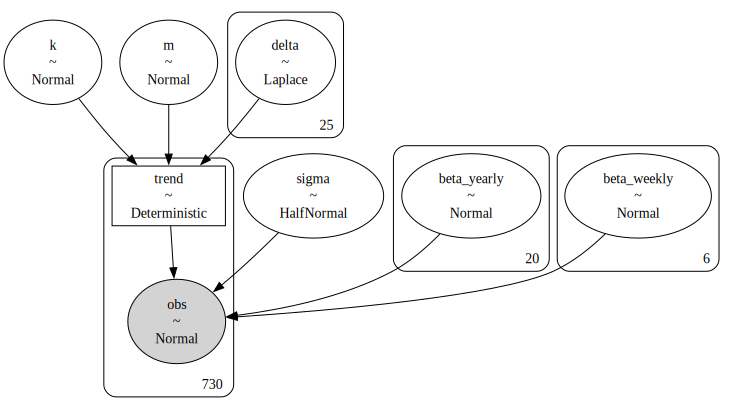

In [6]:
pm.model_to_graphviz(model.model)

/tmp/ipykernel_23064/2558758471.py:122: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


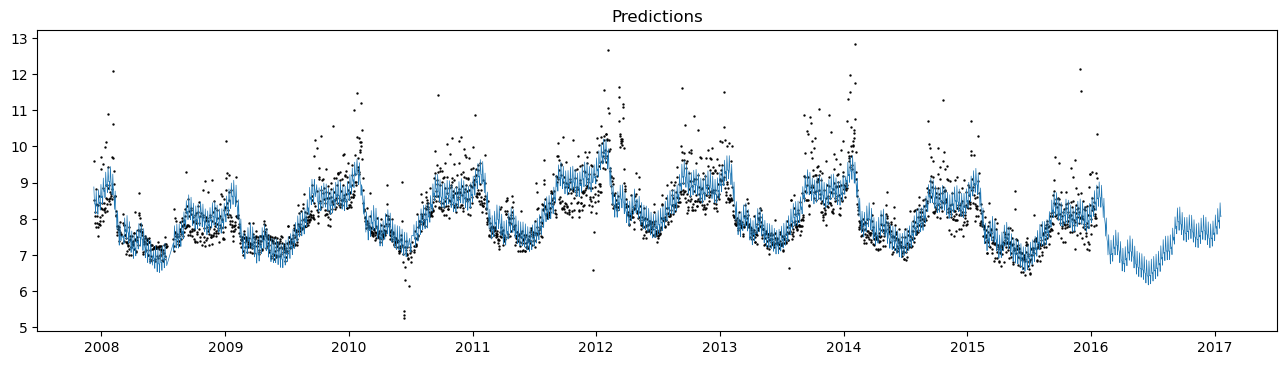

In [7]:
model = MyProphet()
model.fit(df)
preds = model._predict_map(365, plot=True)

In [34]:
model = MyProphet(mcmc_samples=1000)
model.fit(df)
preds = model._predict_mcmc(365, plot=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 792 seconds.
Sampling: [obs]


Output()

TypeError: 'NoneType' object is not subscriptable

/tmp/ipykernel_23064/2443599395.py:122: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


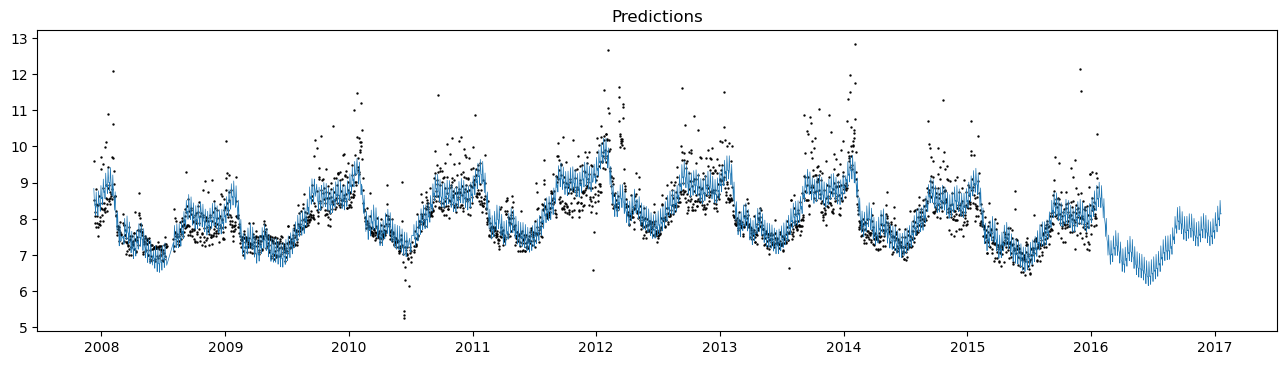

In [35]:
preds = model._predict_mcmc(365, plot=True)

array([[<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'm'}>, <Axes: title={'center': 'm'}>],
       [<Axes: title={'center': 'beta_yearly'}>,
        <Axes: title={'center': 'beta_yearly'}>],
       [<Axes: title={'center': 'beta_weekly'}>,
        <Axes: title={'center': 'beta_weekly'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'trend'}>,
        <Axes: title={'center': 'trend'}>]], dtype=object)

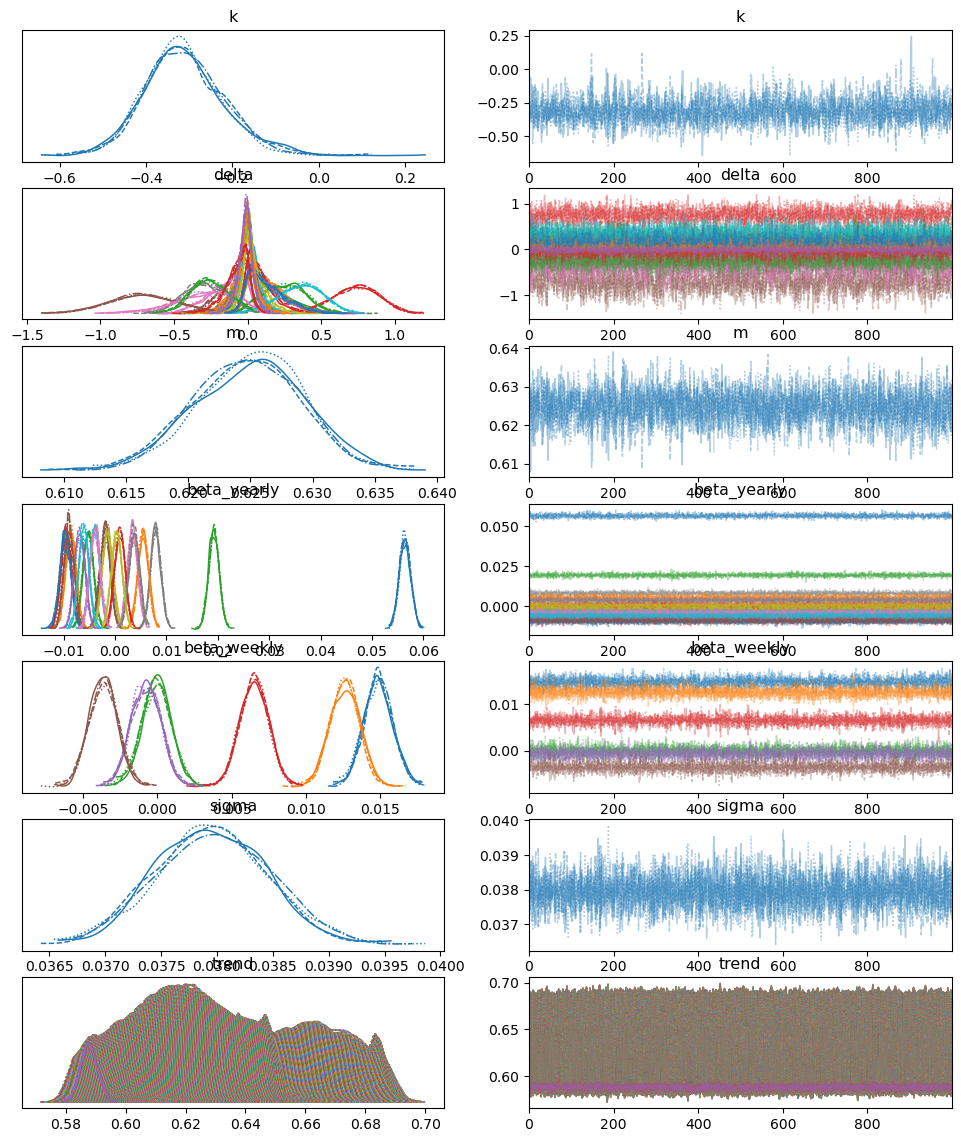

In [36]:
pm.plot_trace(model.trace)

In [52]:
summary = az.summary(model.trace, var_names=["beta_yearly", "beta_weekly", "delta"])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_yearly[0],0.056,0.001,0.054,0.058,0.000,0.000,3990.0,2927.0,1.0
beta_yearly[1],-0.009,0.001,-0.011,-0.007,0.000,0.000,5762.0,2654.0,1.0
beta_yearly[2],-0.005,0.001,-0.007,-0.003,0.000,0.000,5780.0,2843.0,1.0
beta_yearly[3],-0.009,0.001,-0.011,-0.008,0.000,0.000,5693.0,3032.0,1.0
beta_yearly[4],-0.001,0.001,-0.003,0.000,0.000,0.000,4889.0,2661.0,1.0
beta_yearly[5],-0.002,0.001,-0.004,-0.000,0.000,0.000,5827.0,3159.0,1.0
beta_yearly[6],0.003,0.001,0.002,0.005,0.000,0.000,5764.0,3168.0,1.0
beta_yearly[7],0.008,0.001,0.006,0.010,0.000,0.000,5882.0,3178.0,1.0
beta_yearly[8],-0.001,0.001,-0.003,0.000,0.000,0.000,5313.0,2668.0,1.0
beta_yearly[9],-0.004,0.001,-0.006,-0.002,0.000,0.000,5004.0,2821.0,1.0


In [64]:
summary["sd"][[x for x in summary.index if x.startswith("beta_")]].mean()

0.001

In [71]:
window = 730
horizon = 365
yhats = []
ys = []

changepoints_prior_scale = 0.05
seasonality_prior_scale = 10.0
mcmc_samples = 0

# for start in tqdm(range(len(df) - window - horizon - 1)):
for start in tqdm(range(100)):
    if start % 10 == 0:
        mcmc_samples = 1000
    else:
        mcmc_samples = 0

    model = MyProphet(
        mcmc_samples=mcmc_samples,
        changepoints_prior_scale=changepoints_prior_scale,
        seasonality_prior_scale=changepoints_prior_scale,
    )
    model.fit(df[start:start + window])
    
    y = df[start + window:start + window + horizon].copy()
    y["ds"] = pd.to_datetime(y["ds"])
    yhat = model._predict_map(horizon) if mcmc_samples == 0 else model._predict_mcmc(horizon)

    y = y[y["ds"].isin(yhat["ds"])]
    yhat = yhat[yhat["ds"].isin(y["ds"])]

    y["day_idx"] = (y["ds"] - y["ds"].min()).dt.days
    ys.append(y)

    yhat["day_idx"] = (yhat["ds"] - yhat["ds"].min()).dt.days
    yhat["y"] = yhat["yhat"]
    yhat.drop(yhat.columns.difference(["ds", "y", "day_idx"]), axis=1, inplace=True)
    yhats.append(yhat)

    if start % 10 == 0:
        summary = az.summary(model.trace, var_names=["beta_yearly", "beta_weekly", "delta"])
        seasonality_prior_scale = summary["sd"][[x for x in summary.index if x.startswith("beta_")]].mean()
        changepoints_prior_scale = summary["sd"][[x for x in summary.index if x.startswith("delta")]].mean()
        print(seasonality_prior_scale, changepoints_prior_scale)

  0%|                                                                                                                                                                                    | 0/100 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 194 seconds.
Sampling: [obs]


Output()

  1%|█▋                                                                                                                                                                       | 1/100 [03:20<5:30:49, 200.50s/it]

0.002153846153846154 0.06936


 10%|█████████████████                                                                                                                                                          | 10/100 [03:42<06:15,  4.18s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 233 seconds.
Sampling: [obs]


Output()

 11%|██████████████████▌                                                                                                                                                      | 11/100 [07:43<1:53:48, 76.73s/it]

0.0021923076923076926 0.09300000000000001


 20%|██████████████████████████████████▏                                                                                                                                        | 20/100 [08:05<06:53,  5.17s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 244 seconds.
Sampling: [obs]


Output()

 21%|███████████████████████████████████▍                                                                                                                                     | 21/100 [12:16<1:44:02, 79.02s/it]

0.0023461538461538463 0.12312000000000001


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 30/100 [12:39<06:00,  5.15s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 334 seconds.
Sampling: [obs]


Output()

 31%|████████████████████████████████████████████████████                                                                                                                    | 31/100 [18:21<2:02:21, 106.41s/it]

0.0025 0.15560000000000002


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 40/100 [18:45<06:38,  6.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 419 seconds.
Sampling: [obs]


Output()

 41%|████████████████████████████████████████████████████████████████████▉                                                                                                   | 41/100 [25:50<2:09:57, 132.16s/it]

0.0026153846153846158 0.19184


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 50/100 [26:13<06:12,  7.46s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 444 seconds.
Sampling: [obs]


Output()

 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 51/100 [33:42<1:54:20, 140.02s/it]

0.002884615384615385 0.25124


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 60/100 [34:07<05:09,  7.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 445 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [obs]


Output()

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 61/100 [41:39<1:31:39, 141.02s/it]

0.003230769230769231 0.32372


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 70/100 [42:02<03:49,  7.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 448 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [obs]


Output()

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 71/100 [49:38<1:08:42, 142.15s/it]

0.0034230769230769228 0.3998


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 80/100 [50:04<02:40,  8.01s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 448 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [obs]


Output()

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 81/100 [57:38<44:54, 141.82s/it]

0.003653846153846154 0.44880000000000003


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 90/100 [58:03<01:19,  7.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 446 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [obs]


Output()

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 91/100 [1:05:38<21:18, 142.06s/it]

0.003884615384615385 0.5202


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:06:03<00:00, 39.64s/it]


In [72]:
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
metrics = {"horizon": [], "mse": [], "rmse": [], "mae": [], "mape": []}

for k in tqdm(range(horizon)):
    y_true = [y[y["day_idx"] == k]["y"].values[0] for y in ys if k in y["day_idx"].values]
    y_pred = [y[y["day_idx"] == k]["y"].values[0] for y in yhats if k in y["day_idx"].values]
    
    metrics["horizon"].append(k + 1)
    metrics["mse"].append(mean_squared_error(y_true, y_pred))
    metrics["rmse"].append(root_mean_squared_error(y_true, y_pred))
    metrics["mae"].append(mean_absolute_error(y_true, y_pred))
    metrics["mape"].append(mean_absolute_percentage_error(y_true, y_pred))

metrics_df = pd.DataFrame.from_dict(metrics)
metrics_df

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [00:22<00:00, 15.95it/s]


,horizon,mse,rmse,mae,mape
0,1,0.329113,0.573683,0.431952,0.050843
1,2,0.317782,0.563722,0.435986,0.052200
2,3,0.300273,0.547971,0.424266,0.051457
3,4,0.331475,0.575739,0.441445,0.052681
4,5,0.357324,0.597766,0.456167,0.054480
...,...,...,...,...,...
360,361,18.683161,4.322402,3.372584,0.426769
361,362,18.783102,4.333948,3.363359,0.425858
362,363,18.834540,4.339878,3.381879,0.427858
363,364,19.101530,4.370530,3.398552,0.430162


In [108]:
window = 730
horizon = 365
yhats = []
ys = []

for start in tqdm(range(len(df) - window - horizon - 1)):
    model = Prophet()
    model.fit(df[start:start + window])
    future = model.make_future_dataframe(periods=horizon, include_history=False)
    
    y = df[start + window:start + window + horizon].copy()
    y["ds"] = pd.to_datetime(y["ds"])
    yhat = model.predict(future)

    y = y[y["ds"].isin(yhat["ds"])]
    yhat = yhat[yhat["ds"].isin(y["ds"])]

    y["day_idx"] = (y["ds"] - y["ds"].min()).dt.days
    ys.append(y)

    yhat["day_idx"] = (yhat["ds"] - yhat["ds"].min()).dt.days
    yhat["y"] = yhat["yhat"]
    yhat.drop(yhat.columns.difference(["ds", "y", "day_idx"]), axis=1, inplace=True)
    yhats.append(yhat)

100%|███████████████████████████████████████████████████████████████████████████████| 1809/1809 [04:40<00:00,  6.44it/s]


In [109]:
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
metrics = {"horizon": [], "mse": [], "rmse": [], "mae": [], "mape": []}

for k in tqdm(range(horizon)):
    y_true = [y[y["day_idx"] == k]["y"].values[0] for y in ys if k in y["day_idx"].values]
    y_pred = [y[y["day_idx"] == k]["y"].values[0] for y in yhats if k in y["day_idx"].values]
    
    metrics["horizon"].append(k + 1)
    metrics["mse"].append(mean_squared_error(y_true, y_pred))
    metrics["rmse"].append(root_mean_squared_error(y_true, y_pred))
    metrics["mae"].append(mean_absolute_error(y_true, y_pred))
    metrics["mape"].append(mean_absolute_percentage_error(y_true, y_pred))

metrics_df = pd.DataFrame.from_dict(metrics)
metrics_df

100%|█████████████████████████████████████████████████████████████████████████████████| 365/365 [05:24<00:00,  1.13it/s]


,horizon,mse,rmse,mae,mape
0,1,0.310349,0.557090,0.409990,0.048283
1,2,0.329031,0.573613,0.423143,0.049836
2,3,0.343626,0.586196,0.432513,0.051037
3,4,0.358261,0.598549,0.442182,0.052173
4,5,0.368531,0.607067,0.448885,0.052973
...,...,...,...,...,...
360,361,2.355649,1.534812,1.146263,0.140264
361,362,2.364379,1.537654,1.147494,0.140490
362,363,2.370242,1.539559,1.147800,0.140673
363,364,2.397023,1.548232,1.153333,0.141468


In [121]:
window = 730
horizon = 365
yhats = []
ys = []

for start in tqdm(range(len(df) - window - horizon - 1)):
    model = MyProphet()
    model.fit(df[start:start + window])
    
    y = df[start + window:start + window + horizon].copy()
    y["ds"] = pd.to_datetime(y["ds"])
    yhat = model._predict_map(horizon)

    y = y[y["ds"].isin(yhat["ds"])]
    yhat = yhat[yhat["ds"].isin(y["ds"])]

    y["day_idx"] = (y["ds"] - y["ds"].min()).dt.days
    ys.append(y)

    yhat["day_idx"] = (yhat["ds"] - yhat["ds"].min()).dt.days
    yhat["y"] = yhat["yhat"]
    yhat.drop(yhat.columns.difference(["ds", "y", "day_idx"]), axis=1, inplace=True)
    yhats.append(yhat)

100%|█████████████████████████████████████████████████████████████████████████████| 1809/1809 [2:15:43<00:00,  4.50s/it]


In [122]:
metrics = {"horizon": [], "mse": [], "rmse": [], "mae": [], "mape": []}

for k in tqdm(range(horizon)):
    y_true = [y[y["day_idx"] == k]["y"].values[0] for y in ys if k in y["day_idx"].values]
    y_pred = [y[y["day_idx"] == k]["y"].values[0] for y in yhats if k in y["day_idx"].values]
    
    metrics["horizon"].append(k + 1)
    metrics["mse"].append(mean_squared_error(y_true, y_pred))
    metrics["rmse"].append(root_mean_squared_error(y_true, y_pred))
    metrics["mae"].append(mean_absolute_error(y_true, y_pred))
    metrics["mape"].append(mean_absolute_percentage_error(y_true, y_pred))

metrics_df = pd.DataFrame.from_dict(metrics)
metrics_df

100%|█████████████████████████████████████████████████████████████████████████████████| 365/365 [05:49<00:00,  1.05it/s]


,horizon,mse,rmse,mae,mape
0,1,0.310043,0.556815,0.410260,0.048323
1,2,0.329366,0.573904,0.423525,0.049883
2,3,0.343622,0.586193,0.433115,0.051115
3,4,0.358341,0.598616,0.442608,0.052237
4,5,0.369344,0.607737,0.450049,0.053125
...,...,...,...,...,...
360,361,3.171555,1.780886,1.357590,0.166171
361,362,3.210863,1.791888,1.367102,0.167385
362,363,3.239174,1.799771,1.373988,0.168180
363,364,3.234491,1.798469,1.379796,0.169156
